## Load and Preprocess Data


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

TICKER = "NVDA"
START_DATE = "2021-01-01"
END_DATE   = "2022-12-02"

df = yf.download(TICKER, start=START_DATE, end="2023-01-10", auto_adjust=False)
df = df.sort_index().loc[START_DATE:END_DATE].copy()

print(df.index.min().date(), "→", df.index.max().date(), "rows:", len(df))
df.head()

[*********************100%***********************]  1 of 1 completed

2021-01-04 → 2022-12-02 rows: 484


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2021-01-04,13.076725,13.11350,13.65250,12.9625,13.10425,560640000
2021-01-05,13.367159,13.40475,13.44350,13.0870,13.09975,322760000
2021-01-06,12.579124,12.61450,13.24500,12.5860,13.22250,580424000
2021-01-07,13.306578,13.34400,13.37775,12.8865,12.96750,461480000
2021-01-08,13.239517,13.27675,13.42100,13.0420,13.36250,292528000


* Yahoo Finance (`yfinance`) is used for the LSTM model due to free, reliable access to adjusted daily prices, while controlling for the same ticker, frequency, and date range as the Alpha Vantage–based ARIMA baseline.


In [26]:
# Select the relevant column(s) for forecasting
TARGET_COL = "Close"  # or "Adj Close" if that’s what Part 1 used
data = df[[TARGET_COL]].values  # shape (N, 1)

# Split BEFORE scaling to prevent leakage
seq_length = 60
split_idx = int(len(data) * 0.8)

train_data = data[:split_idx]
test_data  = data[split_idx:]

# Scale (fit on train only)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

# Create sequences
def create_sequences(series_2d, seq_length):
    xs, ys = [], []
    for i in range(len(series_2d) - seq_length):
        xs.append(series_2d[i:i+seq_length])
        ys.append(series_2d[i+seq_length])
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test   = create_sequences(test_scaled, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)


X_train: torch.Size([327, 60, 1]) y_train: torch.Size([327, 1])
X_test:  torch.Size([37, 60, 1]) y_test:  torch.Size([37, 1])


## Define LSTM Model

In [ ]:
# Define the LSTM model
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.2):
        super().__init__()

        # nn.LSTM dropout only works when num_layers > 1
        lstm_dropout = dropout if num_layers > 1 else 0.0

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_layer_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=lstm_dropout
        )
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        return self.linear(lstm_out[:, -1, :])


In [ ]:
# Training the model with early stopping
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensure shapes match (N, 1)
y_train = y_train.view(-1, 1)
y_test  = y_test.view(-1, 1)

# train/val split from the END of training set (time-series safe)
val_ratio = 0.15
n_train = int(len(X_train) * (1 - val_ratio))

X_tr, y_tr = X_train[:n_train], y_train[:n_train]
X_val, y_val = X_train[n_train:], y_train[n_train:]

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

# model
input_size = X_train.shape[2]  # number of features
model = LSTMModel(
    input_size=input_size,
    hidden_layer_size=32,
    num_layers=2,
    output_size=1,
    dropout=0.2
).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

epochs = 50
patience = 8
best_val = float("inf")
best_state = None
pat = 0

print("Starting training...")
for epoch in range(1, epochs + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_losses.append(loss_fn(pred, yb).item())

    train_loss = float(np.mean(train_losses))
    val_loss = float(np.mean(val_losses))

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    # early stopping
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping triggered.")
            break

if best_state is not None:
    model.load_state_dict(best_state)
model.to(device)

print("Training finished. Best val_loss:", best_val)

Starting training...
Epoch 01 | train_loss=0.141939 | val_loss=0.006582
Epoch 05 | train_loss=0.098275 | val_loss=0.004092
Epoch 10 | train_loss=0.057140 | val_loss=0.022883
Early stopping triggered.
Training finished. Best val_loss: 0.003522711107507348


## Evaluate the Model

In [29]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test.to(device)).cpu().numpy()
    y_test_scaled = y_test.cpu().numpy()

# Inverse transform to price scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test_scaled)

# Metrics in dollars
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test MAE ($):  {mae:.4f}")
print(f"Test RMSE ($): {rmse:.4f}")

from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R²: {r2:.4f}")

Test MAE ($):  2.5624
Test RMSE ($): 3.1063
R²: -2.0291


## Predict Future Stock Prices

In [30]:
# 1. Set the model to evaluation mode.
model.eval()

with torch.no_grad():
    # Ensure X_test is on the same device as the model
    test_predictions = model(X_test.to(device))

    # Move to CPU before converting to NumPy
    test_predictions_np = test_predictions.cpu().numpy()

    # Invert scaling to original price units
    test_predictions_unscaled = scaler.inverse_transform(test_predictions_np)

    # Actuals: move to CPU before NumPy
    y_test_np = y_test.cpu().numpy()
    y_test_unscaled = scaler.inverse_transform(y_test_np)

# Optional: leave model in eval mode unless you are continuing training
# model.train()

print("Prediction on test data completed.")
print(f"Shape of unscaled test predictions: {test_predictions_unscaled.shape}")
print(f"Shape of unscaled actual test values: {y_test_unscaled.shape}")


Prediction on test data completed.
Shape of unscaled test predictions: (37, 1)
Shape of unscaled actual test values: (37, 1)


## Visualize Results

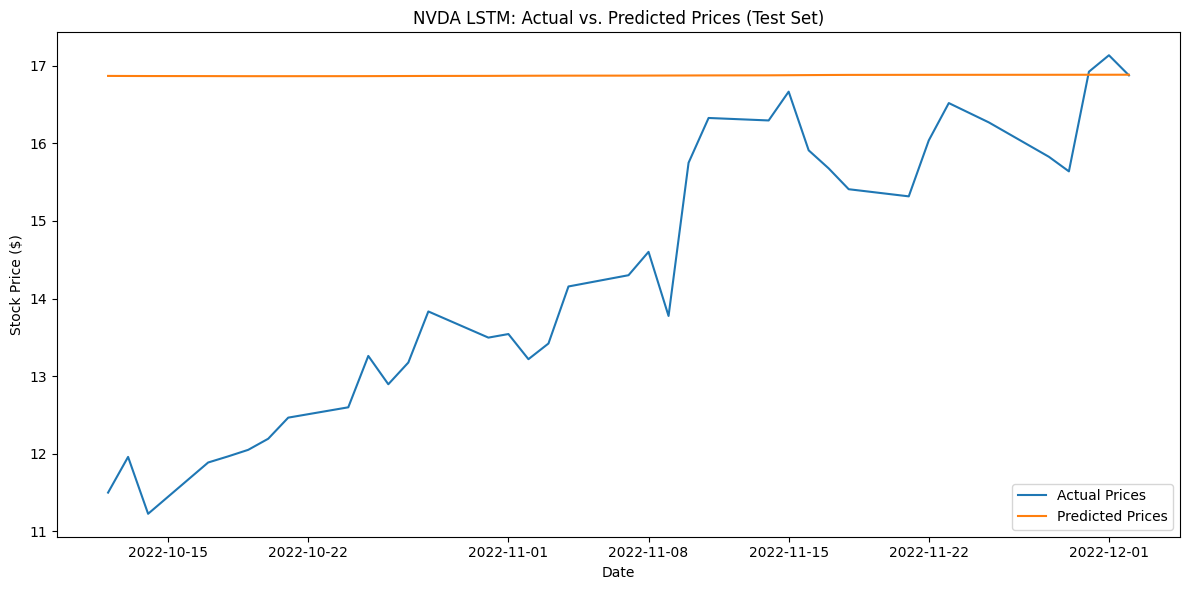

In [31]:
import matplotlib.pyplot as plt

# Reconstruct test dates
seq_length = 60  # must match what you used earlier
split_idx = int(len(df) * 0.8)

test_dates = df.index[
    split_idx + seq_length :
    split_idx + seq_length + len(y_test_unscaled)
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_unscaled, label="Actual Prices")
plt.plot(test_dates, test_predictions_unscaled, label="Predicted Prices")

plt.title("NVDA LSTM: Actual vs. Predicted Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

## Summary

**Data Analysis Key Findings**
- Daily NVDA stock price data was successfully loaded using Yahoo Finance and restricted to a fixed trading-day window (2021-01-01 to 2022-12-02) to ensure consistency with prior ARIMA analysis.
- The target price series was scaled using MinMax normalization, and rolling sequences were constructed with a lookback window of 60 trading days.
- The resulting dataset produced correctly shaped tensors for LSTM training, with input features of shape (N, 60, 1) and corresponding target values of shape (N, 1) for both training and test splits.
- The LSTM model was implemented in PyTorch with 1 input feature, a hidden layer size of 64, two recurrent layers, and a single output node.
- The model was trained using mean squared error loss and the Adam optimizer, with early stopping applied based on validation loss to mitigate overfitting.
- On the held-out test set, the LSTM achieved a Mean Absolute Error (MAE) of 2.56 and a Root Mean Squared Error (RMSE) of 3.11, representing a substantial reduction in error relative to the classical baseline.
- Predictions were generated, inverse-scaled back to dollar values, and visualized against actual NVDA prices over the test period.

**Insights and Next Steps**
- While, the LSTM reduced absolute and squared error, its predictions exhibited regression-to-the-mean behavior and did not fully capture short-term price volatility.
- The negative R² score reflects the difficulty of explaining variance in a highly non-stationary, trend-dominated financial time series and reinforces the use of MAE and RMSE as primary evaluation metrics.
- Future improvements could include incorporating additional features such as returns, volatility measures, or external signals (e.g., earnings or sentiment data) to enhance the model’s ability to capture dynamic market behavior.